<a href="https://colab.research.google.com/github/2Ju1/AI_2024WinterStudy/blob/main/TSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Forecasting - Transformer

##### https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-4.transformer-post/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

,Date,Unnamed: 1,Unnamed: 2,Unnamed: 3,Close,Volume
0,2021-08-10 00:00:00+09:00,NaN,NaN,NaN,9601.42,484265
1,2021-08-11 00:00:00+09:00,NaN,NaN,NaN,9239.94,341902
2,2021-08-12 00:00:00+09:00,NaN,NaN,NaN,9071.58,278558
3,2021-08-13 00:00:00+09:00,NaN,NaN,NaN,8898.27,418731
4,2021-08-17 00:00:00+09:00,NaN,NaN,NaN,8809.14,421803


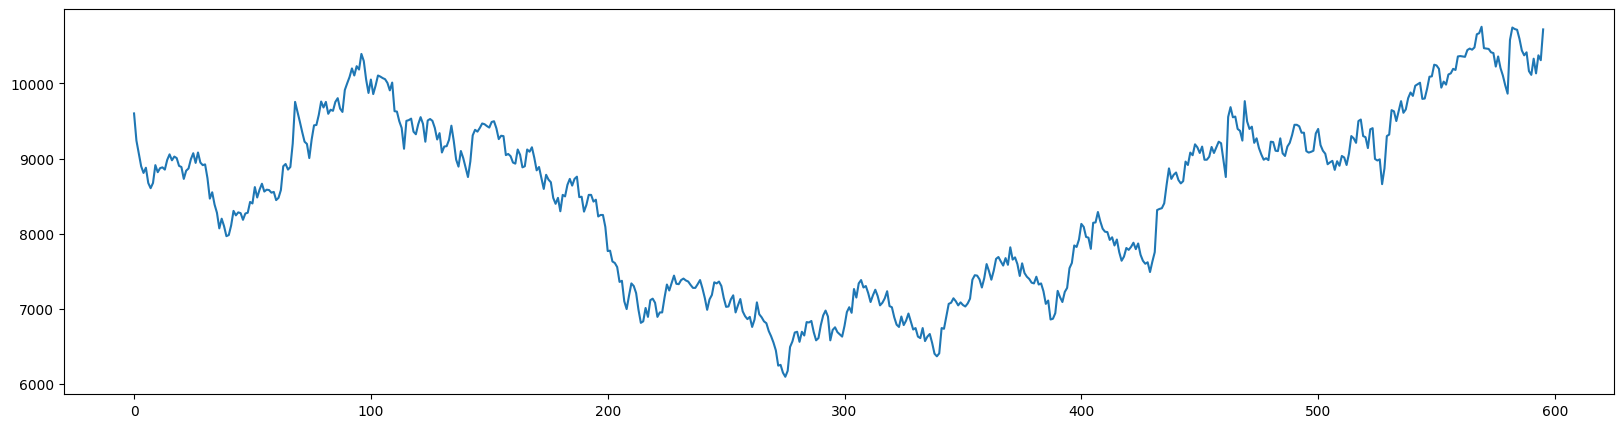

In [ ]:
rawdata = pd.read_csv("historical_prices.csv", encoding='CP949')
plt.figure(figsize=(20,5))
plt.plot(range(len(rawdata)), rawdata["Close"])
rawdata.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
rawdata["Close"] = min_max_scaler.fit_transform(rawdata["Close"].to_numpy().reshape(-1,1))

In [ ]:
# 마지막 5일을 기준으로 둠
train = rawdata[:-5]
data_train = train["Close"].to_numpy()

test = rawdata[-5:]
data_test = test["Close"].to_numpy()

In [ ]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y

        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i, :-1], self.y[i,1:]
    def __len__(self):
        return self.len

In [ ]:
iw = 10
ow = 5

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

In [ ]:
from torch.nn import Transformer
from torch import nn
import torch
import math

In [ ]:
class TFModel(nn.Module):
    def __init__(self,d_model, nhead, nhid, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_encoder_d = PositionalEncoding(d_model, dropout)
        self.linear = nn.Linear(d_model, 1)
        self.encoder = nn.Linear(1, d_model)
        self.encoder_d = nn.Linear(1, d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)

        tgt = self.encoder_d(tgt)
        tgt = self.pos_encoder_d(tgt)
        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask)
        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [ ]:
# cuda는 윈도우 mps는 맥용
#device = torch.device("cuda")
device = torch.device("mps")

lr = 1e-3
model = TFModel(256, 8, 256, 2, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
epoch = 200
from tqdm import tqdm

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0

    for (inputs, dec_inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)

        result = model(inputs.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        loss = criterion(result.permute(1,0,2), outputs.float().to(device))

        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_loader)))

0.00159: 100%|██████████████████████████████| 2000/2000 [18:06<00:00,  1.84it/s]


In [ ]:
def evaluate(length):
    # 윈도우는 될 것 같음
    #input = torch.tensor(data_train[-5*2:]).reshape(1,-1,1).to(device).float().to(device)
    #output = torch.tensor(data_train[-1].reshape(1,-1,1)).float().to(device)

    # 맥용
    input = torch.tensor(data_train[-5*2:], dtype=torch.float32).reshape(1,-1,1).to(device)
    output = torch.tensor(data_train[-1].reshape(1,-1,1), dtype=torch.float32).to(device)

    model.eval()
    for i in range(length):
        src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(output.shape[1]).to(device)

        predictions = model(input, output, src_mask, tgt_mask).transpose(0,1)
        predictions = predictions[:, -1:, :]
        output = torch.cat([output, predictions.to(device)], axis=1)
    return torch.squeeze(output, axis=0).detach().cpu().numpy()[1:]

In [ ]:
result = evaluate(5)
result = min_max_scaler.inverse_transform(result)
real = rawdata["Close"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

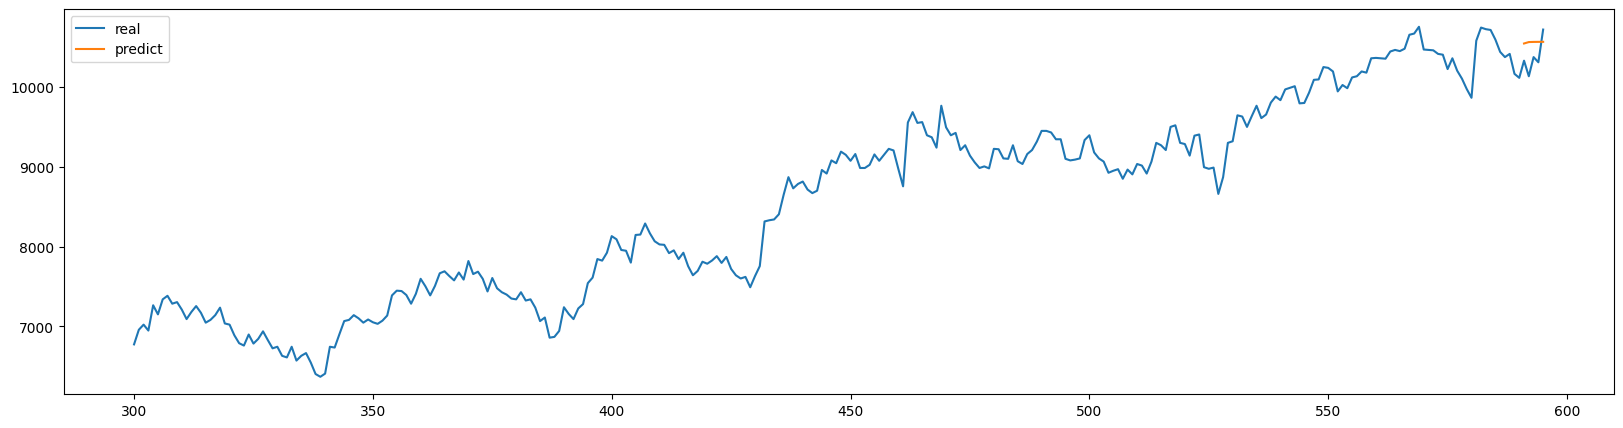

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(range(300,596),real[300:], label="real")
plt.plot(range(596-5,596),result, label="predict")
plt.legend()
plt.show()

In [ ]:
from torch.utils.data import DataLoader, Dataset
class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y

        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [ ]:
iw = 10
ow = 5

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

In [ ]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )

        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        )

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [ ]:
# 윈도우용
#device = torch.device("cuda")

# 맥용
device = torch.device("mps")

lr = 1e-4
model = TFModel(5*2, 5, 512, 8, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
epoch = 1000
model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device),  src_mask)
        loss = criterion(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

loss: 0.000983: 100%|███████████████████████| 1000/1000 [07:44<00:00,  2.15it/s]


In [ ]:
def evaluate():
    # 윈도우 용
    #input = torch.tensor(data_train[-5*2:]).reshape(1,-1,1).to(device).float().to(device)

    # 맥용
    input = torch.tensor(data_train[-5*2:], dtype=torch.float32).reshape(1,-1,1).to(device)
    model.eval()

    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

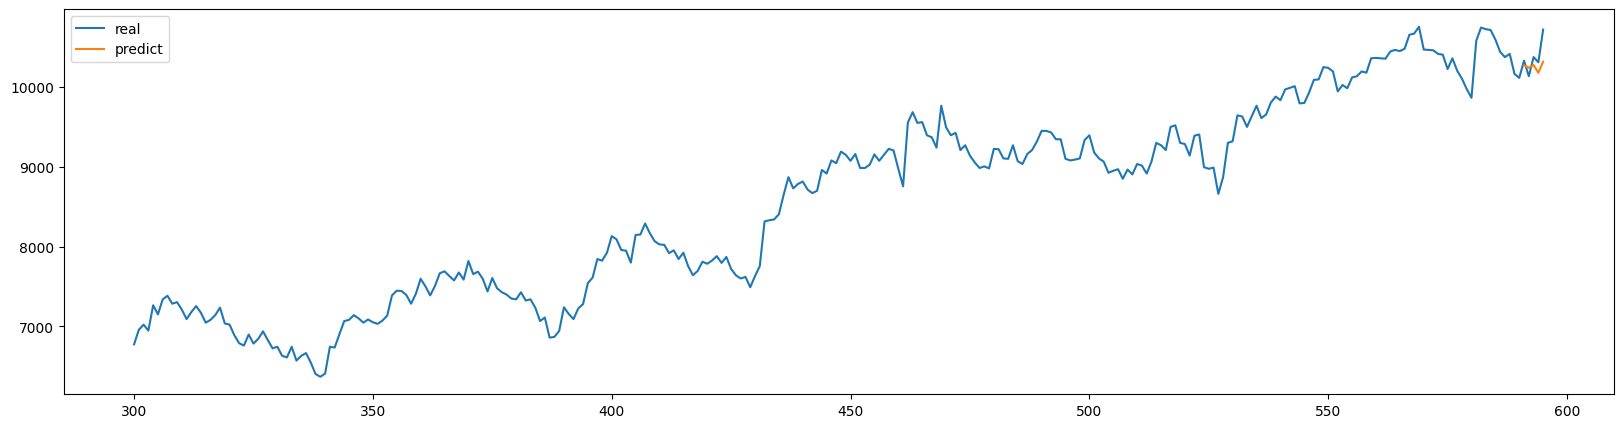

In [ ]:
result = evaluate()
result = min_max_scaler.inverse_transform(result)[0]
real = rawdata["Close"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))[:,0]


plt.figure(figsize=(20,5))
plt.plot(range(300,596),real[300:], label="real")
plt.plot(range(596-5,596),result, label="predict")
plt.legend()
plt.show()

In [ ]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-5:])

1.5216274273603159